In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
%%time
df = pd.read_csv("../data/data_files.csv", encoding= 'unicode_escape') # read the data

CPU times: total: 0 ns
Wall time: 60.3 ms


# Exploratory Data Analysis (EDA)

### Step 1: Let' s take a look at the data

In [3]:
df.sample(5)

,URL,Name
3588,https://raw.githubusercontent.com/kubernetes/k...,GO
8628,https://raw.githubusercontent.com/elastic/elas...,JAVA
22578,https://raw.githubusercontent.com/tensorflow/t...,PYTHON
13997,https://raw.githubusercontent.com/nodejs/node/...,JAVASCRIPT
34415,https://raw.githubusercontent.com/microsoft/vs...,TYPESCRIPT


### Step 2: Number of Unique Values in all the columns

In [4]:
df.nunique()

URL     34720
Name       10
dtype: int64

In [5]:
df.describe()

,URL,Name
count,34723,34723
unique,34720,10
top,https://raw.githubusercontent.com/andrewhodel/...,PYTHON
freq,2,7393


### Step 3: Unique Values in 'Name Column' (Going to be made the target variable)

In [6]:
df['Name'].unique()

array(['G-CODE', 'GAP', 'GDSCRIPT', 'GO', 'JAVA', 'JAVASCRIPT', 'PHP',
       'PYTHON', 'RUBY', 'TYPESCRIPT'], dtype=object)

### Step 4: Duplicate Check for "URL" column (as this column should only have unique urls)

In [7]:
df['URL'].duplicated().sum()

3

### Step 5: Check the info() on the features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34723 entries, 0 to 34722
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     34723 non-null  object
 1   Name    34723 non-null  object
dtypes: object(2)
memory usage: 542.7+ KB


#### conclusion drawn from Step 5:
- both columns are of type 'object'

### Step 6: Check Class Distribution 

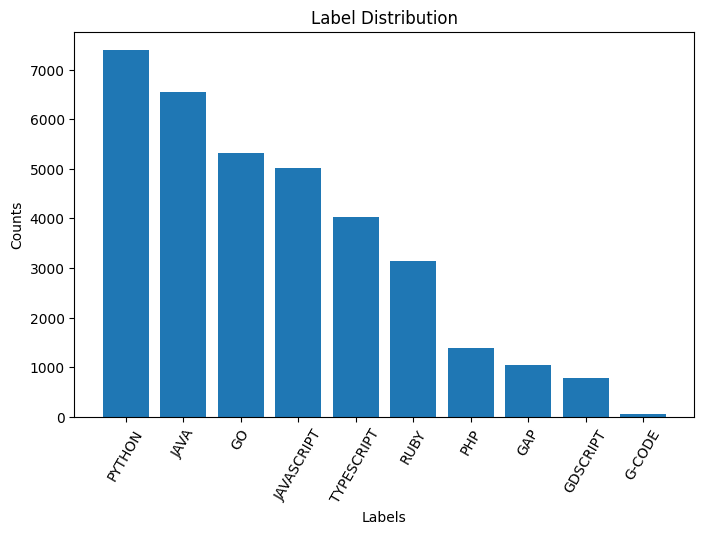

In [9]:
# Get the counts of unique labels within a column
label_counts = df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=60)
plt.title('Label Distribution')
plt.show()

In [10]:
df["Name"].value_counts()

Name
PYTHON        7393
JAVA          6543
GO            5321
JAVASCRIPT    5023
TYPESCRIPT    4034
RUBY          3138
PHP           1379
GAP           1054
GDSCRIPT       779
G-CODE          59
Name: count, dtype: int64

# Function to reduce the dataset

In [11]:
def reduce_dataset(df):
    labels = df["Name"].unique()
    new_df = pd.DataFrame()
    
    length = df[df["Name"] == "GAP"].shape[0]
    
    for label in labels:
        if df[df["Name"] == label].shape[0] >= length:
            new_df = pd.concat([new_df, df[df["Name"] == label].sample(length)], ignore_index=True)
        else:
            new_df = pd.concat([new_df, df[df["Name"] == label]], ignore_index=True)   
    
    return new_df

In [12]:
reduced_df = reduce_dataset(df)

# Class Distribution after reducing the dataset

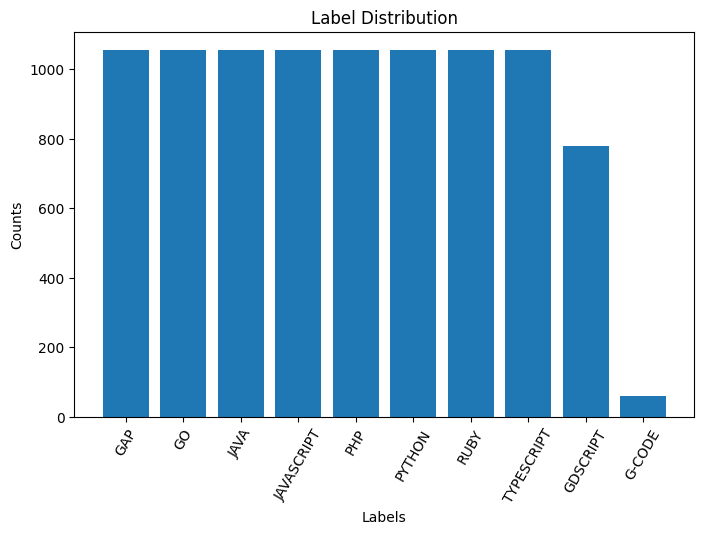

In [13]:
# Get the counts of unique labels within a column
label_counts = reduced_df['Name'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=60)
plt.title('Label Distribution')
plt.show()

In [14]:
reduced_df["Name"].value_counts()

Name
GAP           1054
GO            1054
JAVA          1054
JAVASCRIPT    1054
PHP           1054
PYTHON        1054
RUBY          1054
TYPESCRIPT    1054
GDSCRIPT       779
G-CODE          59
Name: count, dtype: int64

# Function to remove non-ASCII characters from the given text

In [15]:
def remove_non_ascii(text):
    #Remove non-ASCII characters from the given text using a regular expression.
    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', text)
    return cleaned_text

# Function to remove multiple spaces from the text

In [16]:
def remove_multiple_spaces(text):
    multiple_spaces_removed_text = " ".join(text.split()) 
    return multiple_spaces_removed_text

# Custom Transformer classes (So that sklearn's pipeline can be used)

In [17]:
import re
from sklearn.base import BaseEstimator, TransformerMixin
import chardet # an ML model, It uses machine learning to detect the encoding of a file


# Custom transformer to remove numbers from text
class NumberRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Remove numbers using regular expression
        return [re.sub(r'\d+', '', text) for text in X]
    
# Custom transformer to remove non-ASCII characters from the given text using a regular expression.
class NonASCIIRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # remove non-ASCII characters from the given text using a regular expression.
        return [re.sub(r'[^\x00-\x7F]+', '', text) for text in X]

# Custom transformer to remove multiple spaces from the content
class MultipleSpacesRemovalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #  remove multiple spaces from the content
        return [" ".join(text.split()) for text in X]


class UrlToContentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for url in X:
            while True:
                try:    
                    response = requests.get(url)
                    content = response.content
                    encoding = chardet.detect(content)
        
                    if encoding['encoding'] == "ISO-8859-1":
                        decoded_content = content.decode("iso-8859-1")
                    elif encoding['encoding'] == "GB2312":
                        decoded_content = content.decode("GB2312")
                    else:
                        decoded_content = content.decode("utf-8")

                    transformed_X.append(decoded_content)
                    break
                except Exception as e:
                    decoded_content = content.decode("utf-8")
                    transformed_X.append(decoded_content)
                    break
        return transformed_X


# Create a Pipeline for the basic text pre-processing

In [18]:
from sklearn.pipeline import Pipeline

# Define the preprocessing steps
pipeline_preprocessing = Pipeline([
    ('url_to_content', UrlToContentTransformer()),
    ('non_ascii_removal', NonASCIIRemovalTransformer()),
    ('mutiple_space_removeal', MultipleSpacesRemovalTransformer()),
    ('number_removal', NumberRemovalTransformer()),
])

#### Apply the preprocessing pipeline to the dataset

In [19]:
%%time
reduced_df['Content'] = pipeline_preprocessing.fit_transform(reduced_df['URL'])

CPU times: total: 2min 13s
Wall time: 42min 27s


#### Visualise the datset after the preprocessing pipeline

In [20]:
reduced_df['Content']

0       ; GL HV - by Wangibangi M G E M S M S G G Z F ...
1       ; G-Code generated by SimplifyD(R) Version .. ...
2       ; G-Code generated by SimplifyD(R) Version .. ...
3       ; G-Code generated by SimplifyD(R) Version .. ...
4       ; G-Code generated by SimplifyD(R) Version .. ...
                              ...                        
9265    /*--------------------------------------------...
9266    /*--------------------------------------------...
9267    /*--------------------------------------------...
9268    /*--------------------------------------------...
9269    /*--------------------------------------------...
Name: Content, Length: 9270, dtype: object

# Seperate the dataset into Independent and target variables

In [21]:
X = reduced_df['Content']
y = reduced_df['Name']

# Train-Test-Validation split

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training set (80%) and temporary set (20%)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation set (10%) and final training set (90%)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.1, random_state=42)

# NLP techniques

- #### Bag-of-Words (CountVectorizer)
- #### n-grams
- #### TF-IDF
- ##### Byte-Pair Encoding

In [23]:
# Bag-of-words can be implemented using "CountVectorizer" in sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tokenizers import ByteLevelBPETokenizer

#### Custom Transformer for  Byte-Pair Encoding (Discarded for now)

In [24]:
class BPEVectorizer:
    def __init__(self, vocab_size=3000): # default vocab_size is 30000 try with that too
        self.vocab_size = vocab_size
        self.tokenizer = ByteLevelBPETokenizer()

    def fit(self, X, y=None):
        texts = [text for text in X]
        self.tokenizer.train_from_iterator(texts, vocab_size=self.vocab_size, special_tokens=["<s>", "<pad>", "</s>", "<unk>"])
        return self

    def transform(self, X, max_length=1000):
        encoded_texts = [self.tokenizer.encode(text).ids for text in X]
        # Pad or truncate sequences to a fixed length of max_length
        padded_texts = [ids[:max_length] + [0] * (max_length - len(ids)) if len(ids) < max_length else ids[:max_length] for ids in encoded_texts]

        return np.array(padded_texts)


# Hyper-Parameter Tuning using GridSearchCV

#### Define a list of NLP techniques (vectorizers) with their hyperparameter grids

In [25]:
vectorizers = [
#     (BPEVectorizer(), {}),
    
    (CountVectorizer(), {
        'vectorizer__max_features': [1000, 2000, 3000],
        'vectorizer__ngram_range': [(1, 1), (1, 2)]
    }),
    
    (TfidfVectorizer(), {
        'vectorizer__max_df': [0.8, 0.9, 1.0],
        'vectorizer__min_df': [1, 2, 3],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'vectorizer__use_idf': [True, False],
    }),
    
]

#### Define a list of classifiers with their hyperparameter grids

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

classifiers = [
    (LogisticRegression(), {'clf__C': [0.1, 1, 10], 'clf__max_iter': [500, 1000]}),
    (MultinomialNB(), {'clf__alpha': [0.1, 1, 10]}),
    (SVC(), {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}),
    (RandomForestClassifier(), {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 10, 20]})
]

#### Perform GridSearchCV for hyperparameter tuning for all combinations

In [27]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

best_model = None
best_f1_score = 0

for vectorizer, vectorizer_params in vectorizers:
    for classifier, classifier_params in classifiers:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('clf', classifier)
        ])

        param_grid = {**vectorizer_params, **classifier_params}

        grid_search = GridSearchCV(pipeline, 
                                   param_grid=param_grid, 
                                   cv=5, 
                                   scoring=make_scorer(f1_score, average='weighted'),
                                   
                                   
                                   
#                                    n_jobs=multiprocessing.cpu_count(),
                                   verbose=1  # Provide progress updates
        )
        grid_search.fit(X_train, y_train)
        
        # Evaluate the model on the validation set
        validation_f1_score = f1_score(
            y_val, 
            grid_search.best_estimator_.predict(X_val), 
            average='weighted'
        )

        score = grid_search.best_score_

        print(f"Vectorzier: {vectorizer.__class__.__name__}, Classifier: {classifier.__class__.__name__}")
        print("Best Hyperparameters:", grid_search.best_params_)
        print("Cross-Validation Best F1-Score:", score)
        print("Validation Set F1-Score:", validation_f1_score)
        print()
        

        if score > best_f1_score:
            best_f1_score = score
            best_model = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Vectorzier: CountVectorizer, Classifier: LogisticRegression
Best Hyperparameters: {'clf__C': 0.1, 'clf__max_iter': 500, 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 1)}
Cross-Validation Best F1-Score: 0.9730002355665981
Validation Set F1-Score: 0.9783674535144511

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Vectorzier: CountVectorizer, Classifier: MultinomialNB
Best Hyperparameters: {'clf__alpha': 0.1, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 1)}
Cross-Validation Best F1-Score: 0.9659488376225991
Validation Set F1-Score: 0.967481124577558

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Vectorzier: CountVectorizer, Classifier: SVC
Best Hyperparameters: {'clf__C': 0.1, 'clf__kernel': 'linear', 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 2)}
Cross-Validation Best F1-Score: 0.9508661432145276
Validation Set F1-Score: 0.96090301115279

In [28]:
best_model

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=2000)),
                ('clf', RandomForestClassifier(n_estimators=50))])

# WordCloud Analysis for Classes

In [29]:
from wordcloud import WordCloud


# Get the unique class labels from y_train
unique_classes = np.unique(y_train)

# Get teh vectorizer from the model pipeline
best_vectorizer = best_model.named_steps['vectorizer']

feature_names = best_vectorizer.get_feature_names_out()
X_bow_train = best_vectorizer.transform(X_train)

# Define a dictionary to store the BoW data for each class
class_bow_data = {label: {feature_names[j]: 0 for j in range(X_bow_train.shape[1])} for label in unique_classes}

# Initialize an empty dictionary to store the combined data
combined_data = {}


# Group the BoW data based on class labels
for label1 in unique_classes:
    for index, label2 in enumerate(y_train):
        # Get the i-th document's word frequencies
        word_frequencies = {feature_names[j]: X_bow_train[index, j] for j in range(X_bow_train.shape[1])}
        # Iterate through the list of dictionaries
        if label1 == label2:
            for key, value in word_frequencies.items():
                if key in combined_data:
                    combined_data[key] += value
                else:
                    combined_data[key] = value
            class_bow_data[label1] = combined_data


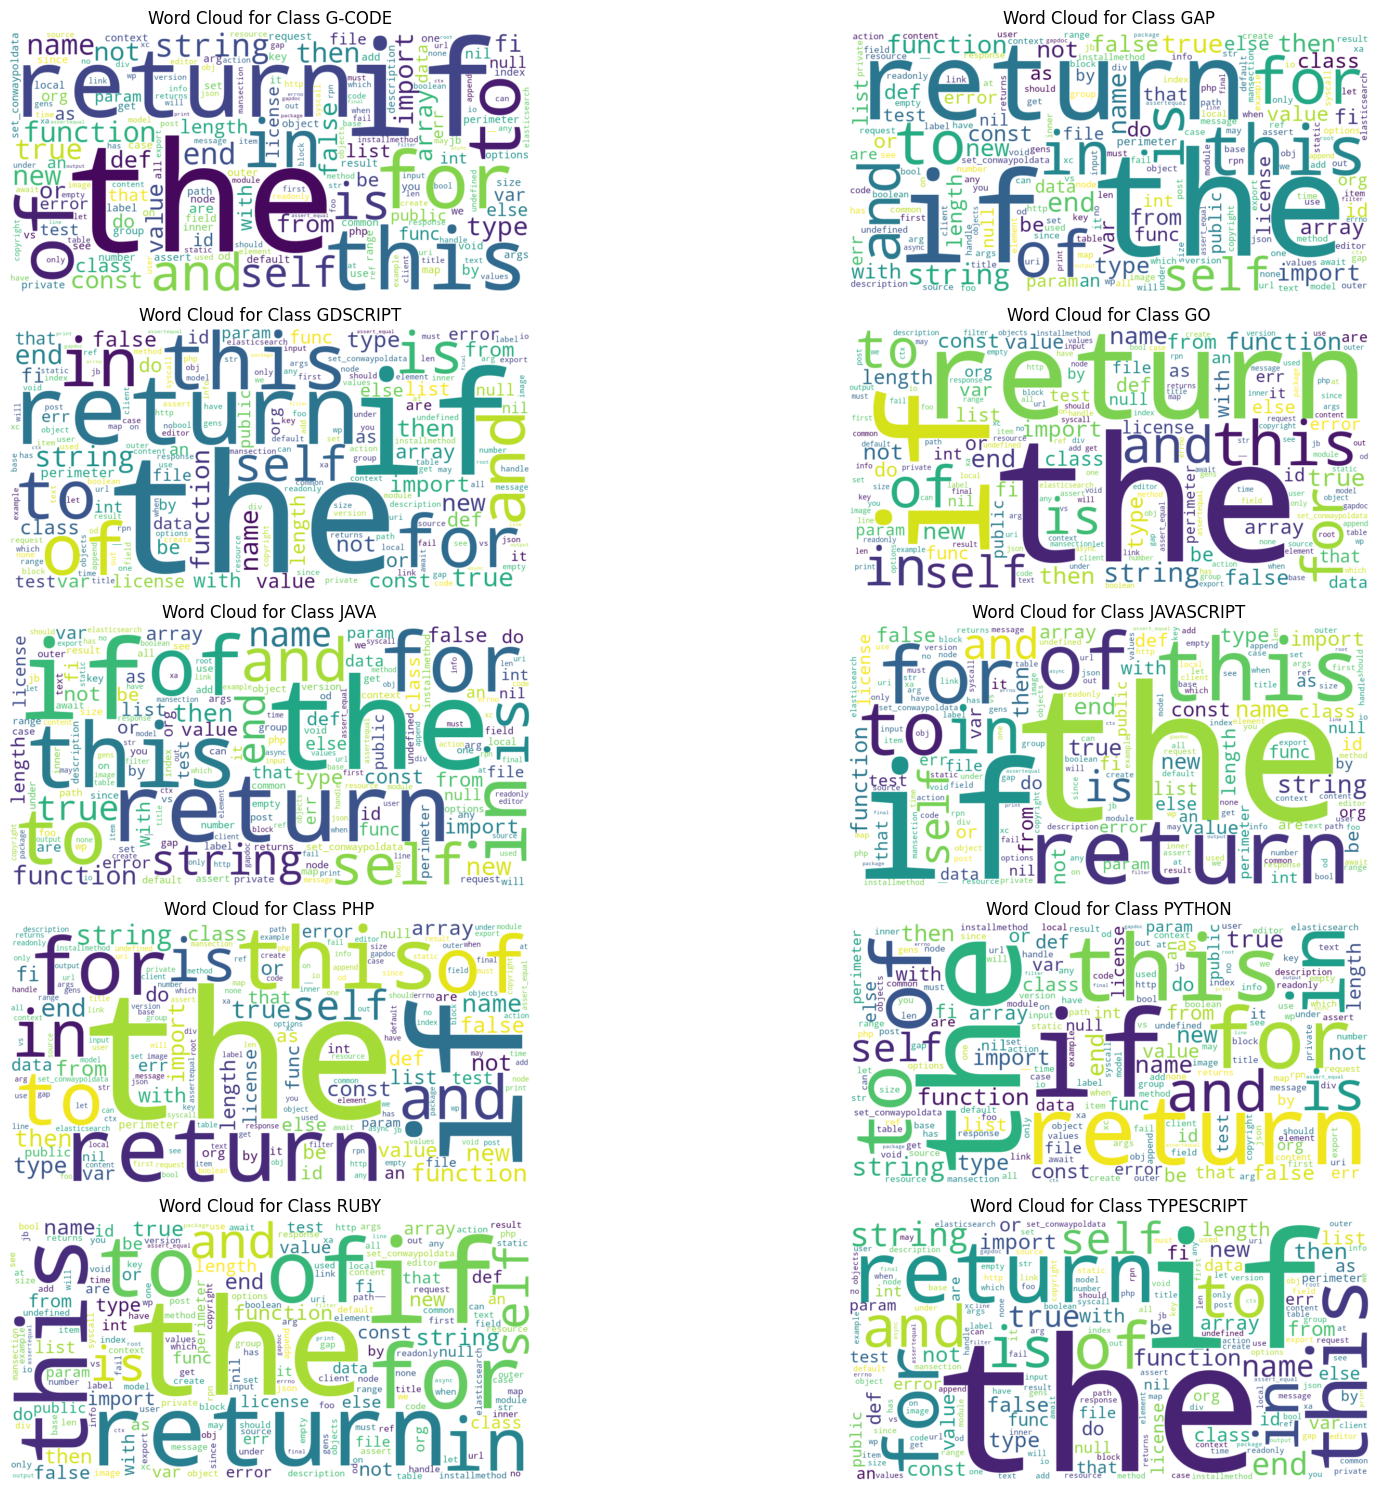

In [30]:
# Generate Word Clouds
wordcloud = WordCloud(width=1000, height=500, background_color='white')

# Calculate the number of unique classes
num_classes = len(unique_classes)

# Create subplots with two columns
num_cols = 2
num_rows = (num_classes + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

# Flatten the axes if needed
if num_rows > 1:
    axes = axes.flatten()

# Iterate over unique classes and create word clouds
for idx, label in enumerate(unique_classes):
    # Combine all BoW vectors for the current class
    word_frequencies = class_bow_data[label]

    # Plot the word cloud in the appropriate subplot
    ax = axes[idx]
    wordcloud.generate_from_frequencies(word_frequencies)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud for Class {label}')
    ax.axis('off')

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.show()

# Evaluate the model

### Prection on test data

In [31]:
y_pred = best_model.predict(X_test)

### Step 1: Accuracy

In [32]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9897518878101402


### Step 2: Precision

In [33]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='weighted')
print(precision)

0.9898495642715647


### Step 3: Recall

In [34]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='weighted')
print(recall)

0.9897518878101402


### Step 4: F1-score

In [35]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

0.9896142452303396


### Step 5: Classfication Report (Summary of steps 1-4)

In [36]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      G-CODE       1.00      0.73      0.85        15
         GAP       0.98      0.98      0.98       212
    GDSCRIPT       1.00      0.99      1.00       154
          GO       1.00      0.98      0.99       200
        JAVA       0.99      1.00      0.99       214
  JAVASCRIPT       0.98      0.99      0.98       215
         PHP       1.00      1.00      1.00       196
      PYTHON       0.97      0.99      0.98       210
        RUBY       1.00      1.00      1.00       222
  TYPESCRIPT       1.00      1.00      1.00       216

    accuracy                           0.99      1854
   macro avg       0.99      0.97      0.98      1854
weighted avg       0.99      0.99      0.99      1854



### Step 6: Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

#### Plot Confusion Matrix

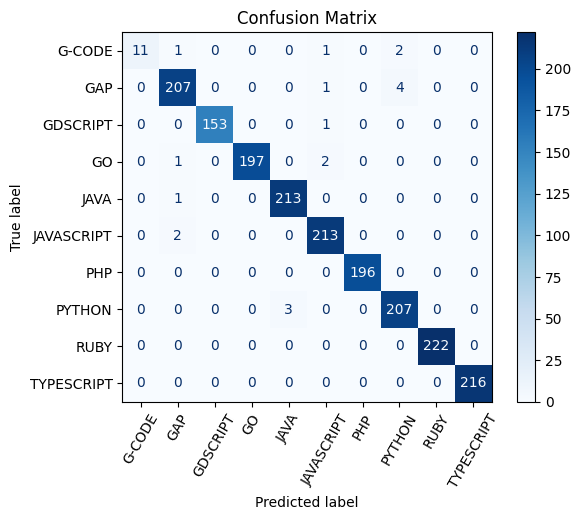

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='.0f')
plt.title('Confusion Matrix')
plt.xticks(rotation=60)
plt.show()

# Save the model

In [39]:
import os

print(os.getcwd())
print(os.path.dirname(os.getcwd()))

C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub\notebooks
C:\Users\kiran\Desktop\Analysis-of-GAP-programming-practices-on-GitHub


In [40]:
import pickle

# Full pipeline with preprocessing and classifier
full_pipeline = Pipeline([
    ('pipeline_preprocessing', pipeline_preprocessing),
    ('classifier_and_vectorizer', best_model)
])

# Save the full_pipeline object
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
os.makedirs(clf_folder_path, exist_ok=True)
clf_file_path = os.path.join(clf_folder_path, 'classifier2.pkl')

with open(clf_file_path, 'wb') as f:
    pickle.dump(full_pipeline, f)


# Load the saved model and see whether working or not

In [41]:
import joblib

# Load the saved pipeline
clf_folder_path = os.path.join(os.path.dirname(os.getcwd()), "model")
clf_file_path = os.path.join(clf_folder_path, 'classifier2.pkl')
loaded_pipeline = joblib.load(clf_file_path)

# Use the loaded pipeline for predictions or other operations
predictions = loaded_pipeline.predict(['https://raw.githubusercontent.com/opencv/opencv/3aeaa3402389fc55e53fbc6f5741ca29f51032ee/modules/core/misc/java/src/java/core%2BMat.java'])

# Prediction

In [42]:
predictions

array(['JAVASCRIPT'], dtype=object)